In [1]:
import pandas as pd
import sweetviz as sv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OrdinalEncoder

# Clean Data

In [2]:
df_user = pd.read_csv('./csv/dtt_users.csv')
df_country = pd.read_csv('./csv/dtt_country.csv')[['country_id','country_code','country_phonecode','country_name']]

order_col = [
    'customer_id','order_product_id','browser', 'platform', # ref
    'customer_firstname','customer_lastname','customer_email','customer_gender', #customer details
    'customer_nationality','customer_country','customer_phone_iso','customer_phone_code', # convert to country id
    'order_price_paid','order_state','order_payment_by',
    'order_quantity_infant','order_quantity_children','order_quantity_adult','order_quantity_elder', # create private, group, family, kid, adult
    'order_departure_date','date_create',# columns >> date in year, mount, year
    ]
df_order = pd.read_csv('./csv/dtt_order.csv')[order_col]

id_to_countryCode = {i[1][0] : i[1][3] for i in df_country.iterrows()}
countryCode_to_id = {i[1][1] : i[1][0] for i in df_country.iterrows()}
phoneCode_to_id = {}
countryName_to_id = {i[1][3] : i[1][0] for i in df_country.iterrows()}
for i in df_country.iterrows():
    val = i[1][0]
    if len(i[1][2].split(',')) > 1:
        for j in i[1][2].split(','):
            phoneCode_to_id[j] = val
    else:
        phoneCode_to_id[i[1][2]] = val

/var/folders/5g/90_bh_2146gffg2__wzbyb780000gn/T/ipykernel_34298/1391352701.py:12: DtypeWarning: Columns (2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_order = pd.read_csv('./csv/dtt_order.csv')[order_col]


In [3]:
def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

def encode_gender(inputString):
    if 'Mr.' == inputString or 'mr.' in inputString:
        return 0
    elif 'Ms.' == inputString or 'ms.' in inputString:
        return 1
    elif 'Mrs.' == inputString or 'mrs.' in inputString:
        return 2
    else:
        return 3

def encode_phone_code(inputFloat):
    try:
        return phoneCode_to_id[str(int(inputFloat))]
    except:
        print(int(inputFloat))

def encode_order_payment_by(inputString):
    if 'creditcard' == inputString:
        return 1
    elif 'paypal' == inputString:
        return 2
    else:
        return 0

In [4]:
df_order_v1 = df_order[order_col]
# drop na
na_index_v1 = df_order_v1[df_order_v1['customer_country'].isna()].index
df_order_v1 = df_order_v1.drop(na_index_v1)

# drop test
test_index_v1 = df_order_v1[df_order_v1['customer_email'].map(lambda x: 'test' in str(x) or '@mail.com' in str(x) or '360' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v1)

test_index_v2 = df_order_v1[df_order_v1['customer_email'].map(lambda x: 'mitkung' in str(x) or 'suphattra' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v2)

test_index_v3 = df_order_v1[df_order_v1['customer_firstname'].map(lambda x: 'admin' in str(x) or 'test' in str(x) or 'Thanadol' in str(x) or 'Test' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v3)

test_index_v3 = df_order_v1[df_order_v1['customer_firstname'].map(lambda x: ('asd' in str(x) or 'dsd' in str(x) or 'xx' in str(x)) and not 'Jasdeep' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v3)

# clean
df_order_v1.loc[3627, 'customer_firstname'] = 'Jennyhan'
df_order_v1['customer_firstname'] = df_order_v1['customer_firstname'].map(lambda x: re.sub('[0-9#$;:]+', '', x))
df_order_v1['customer_lastname'] = df_order_v1['customer_lastname'].map(lambda x: re.sub('[0-9#$;:]+', '', x))
df_order_v1['customer_nationality'] = df_order_v1['customer_nationality'].map(lambda x: re.sub('ไทย|Thailand', 'thai', x))
df_order_v1['customer_nationality'] = df_order_v1['customer_nationality'].map(lambda x : x.lower())

# encode
df_order_v1['customer_gender'] = df_order_v1['customer_gender'].map(lambda x : encode_gender(str(x)))
df_order_v1['customer_country'] = df_order_v1['customer_country'].map(lambda x : countryName_to_id[x] if x != '' else x)

df_order_v1.fillna(value={'customer_phone_iso': -1, 'customer_phone_code':-1, 'order_payment_by': 0}, inplace=True)
df_order_v1['customer_phone_iso'] = df_order_v1['customer_phone_iso'].map(lambda x : -1 if x == -1 else countryCode_to_id[x])
df_order_v1['customer_phone_code'] = df_order_v1['customer_phone_code'].map(lambda x : -1 if x == -1 else encode_phone_code(x))
df_order_v1['order_payment_by'] = df_order_v1['order_payment_by'].map(lambda x : encode_order_payment_by(str(x)))

df_order_v1['customer_phone_iso'] = np.where(df_order_v1['customer_phone_iso']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])
df_order_v1['customer_phone_code'] = np.where(df_order_v1['customer_phone_code']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])

enc = OrdinalEncoder(dtype='int8', encoded_missing_value=-1)
cat_cols = ['browser', 'platform', 'order_state']
df_order_v1[cat_cols] = enc.fit_transform(df_order_v1[cat_cols])

# change dtype to int
int_cols = ['customer_phone_iso', 'customer_phone_code','order_price_paid', 'customer_id']
df_order_v1['customer_phone_iso'] = np.where(df_order_v1['customer_phone_iso']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])
df_order_v1['customer_phone_code'] = np.where(df_order_v1['customer_phone_code']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])
df_order_v1[int_cols] = df_order_v1[int_cols].astype('int64')

# convert to datetime
df_order_v1[['order_departure_date','date_create']] = df_order_v1[['order_departure_date','date_create']].apply(pd.to_datetime)

df_order_v1['booked_days'] =  df_order_v1['order_departure_date'] - df_order_v1['date_create']
df_order_v1['booked_days'] = df_order_v1['booked_days'].map(lambda x: x.days if x.days >= 0 else 0)

df_order_v1['departure_year'] = df_order_v1['order_departure_date'].map(lambda x:x.year)
df_order_v1['departure_month'] = df_order_v1['order_departure_date'].map(lambda x:x.month)
df_order_v1['departure_day'] = df_order_v1['order_departure_date'].map(lambda x:x.day)

df_order_v1['departure_DayofYear'] = df_order_v1['order_departure_date'].map(lambda x:x.day_of_year)
df_order_v1['departure_DayofWeek'] = df_order_v1['order_departure_date'].map(lambda x:x.day_of_week)

# Majority Vote for country code
df_order_v1['Majority_code'] = df_order_v1[['customer_country','customer_phone_iso','customer_phone_code']].mode(axis=1)

# sum of kid  and adult
df_order_v1['sum_kids'] = df_order_v1['order_quantity_infant'] + df_order_v1['order_quantity_children']
df_order_v1['sum_adults'] = df_order_v1['order_quantity_adult'] + df_order_v1['order_quantity_elder']

df_order_v1['private'] = np.where((df_order_v1['sum_kids'] == 0) & (df_order_v1['sum_adults'] <= 2), 1, 0)
df_order_v1['group'] = np.where((df_order_v1['sum_kids'] == 0) & (df_order_v1['sum_adults'] > 2), 1, 0)
df_order_v1['family'] = np.where((df_order_v1['sum_kids'] > 0) & (df_order_v1['sum_adults'] > 0), 1, 0)

In [5]:
enc.categories_

[array(['Android Browser', 'AppleWebKit', 'Chrome', 'Edge', 'Firefox',
        'MSIE', 'Opera Next', 'Safari', 'SamsungBrowser', 'Vivaldi', nan],
       dtype=object),
 array(['Android', 'Chrome OS', 'Linux', 'Macintosh', 'Windows', 'iPad',
        'iPhone', nan], dtype=object),
 array(['cancelled', 'detail_success', 'payment_success'], dtype=object)]

In [6]:
df_order_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9250 entries, 1285 to 27326
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              9250 non-null   int64         
 1   order_product_id         9250 non-null   int64         
 2   browser                  9250 non-null   int8          
 3   platform                 9250 non-null   int8          
 4   customer_firstname       9250 non-null   object        
 5   customer_lastname        9250 non-null   object        
 6   customer_email           9250 non-null   object        
 7   customer_gender          9250 non-null   int64         
 8   customer_nationality     9250 non-null   object        
 9   customer_country         9250 non-null   int64         
 10  customer_phone_iso       9250 non-null   int64         
 11  customer_phone_code      9250 non-null   int64         
 12  order_price_paid         9250 

In [7]:
df_order_v1

,customer_id,order_product_id,browser,platform,customer_firstname,customer_lastname,customer_email,customer_gender,customer_nationality,customer_country,...,departure_month,departure_day,departure_DayofYear,departure_DayofWeek,Majority_code,sum_kids,sum_adults,private,group,family
1285,0,121,2,0,Julie,Staplea,juliestaples40@gmail.com,2,british,77,...,10,29,302,0,77,0,2,1,0,0
1286,0,121,2,0,Julie,Staples,juliestaples40@gmail.com,2,british,77,...,10,29,302,0,77,0,2,1,0,0
1296,0,55,7,6,Chad,Steedman,chad.steedman@hotmail.com,0,australian,13,...,8,30,242,3,13,3,2,0,0,1
1300,0,90,7,6,Dale,Lewis,juleslewis@hotmail.co.uk,0,welsh,77,...,8,31,243,4,77,0,2,1,0,0
1303,0,127,2,0,Samer,Zainal,s.zainal@gmail.com,0,bahrain,23,...,8,30,242,3,23,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27311,2824,122,2,4,Ann Mary,Baby,annmarybaby5@gmail.com,0,india,105,...,2,15,46,2,105,0,2,1,0,0
27318,0,202,7,6,Reneta,Gesheva,rgesheva8@gmail.com,2,american,233,...,1,21,21,5,233,0,2,1,0,0
27320,0,195,2,0,Odmunkh,Ebkhbold,odmunkh@yahoo.com,0,mongolia,147,...,1,17,17,1,147,0,5,0,1,0
27323,2826,123,7,6,Harsh Vardhan,Rathi,harshrathi1119@gmail.com,0,indian,105,...,1,17,17,1,105,0,1,1,0,0


In [23]:
# select the columns for EDA and ML
clean_cols = [
    'customer_id', 'order_product_id', 'browser', 'platform', # int category
    'customer_firstname', 'customer_lastname', 'customer_email', # object
    'customer_gender', 'Majority_code',  # int category
    'order_price_paid', # int value
    'order_payment_by', # int category
    'booked_days', 'departure_year', 'departure_month', 'departure_day','departure_DayofYear', 'departure_DayofWeek', # int category
    'sum_kids', 'sum_adults', # int value
    'private', 'group', 'family' # int category
    ]

df_clean = df_order_v1[df_order_v1['order_state']==2][clean_cols]

In [24]:
df_clean

,customer_id,order_product_id,browser,platform,customer_firstname,customer_lastname,customer_email,customer_gender,Majority_code,order_price_paid,...,departure_year,departure_month,departure_day,departure_DayofYear,departure_DayofWeek,sum_kids,sum_adults,private,group,family
1286,0,121,2,0,Julie,Staples,juliestaples40@gmail.com,2,77,4500,...,2018,10,29,302,0,0,2,1,0,0
1296,0,55,7,6,Chad,Steedman,chad.steedman@hotmail.com,0,13,3440,...,2018,8,30,242,3,3,2,0,0,1
1303,0,127,2,0,Samer,Zainal,s.zainal@gmail.com,0,23,699,...,2018,8,30,242,3,0,1,1,0,0
1309,0,90,7,6,Tai,Nguyen,taimusicpro@gmail.com,0,13,2250,...,2018,8,31,243,4,2,3,0,0,1
1310,0,46,2,0,Abhay,arya,abhayarya@hotmail.com,0,198,4100,...,2018,9,1,244,5,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27297,0,34,2,4,Noeleen,Sonego,noeleens@cdmaust.com.au,1,13,4800,...,2023,2,7,38,1,0,2,1,0,0
27300,0,202,2,0,Alex,Schetinin,shatz.g@gmail.com,0,103,3980,...,2023,1,16,16,0,1,2,0,0,1
27309,0,47,2,4,Peter,Naegelein,peter.naegelein@gmx.de,0,158,1760,...,2023,1,18,18,2,1,2,0,0,1
27318,0,202,7,6,Reneta,Gesheva,rgesheva8@gmail.com,2,233,4280,...,2023,1,21,21,5,0,2,1,0,0


In [25]:
df_clean.customer_firstname.value_counts()

Michael      40
Paul         31
David        29
Mark         27
Daniel       25
             ..
Camila        1
Hung          1
RYOTARO       1
Dongwook      1
Aleksandr     1
Name: customer_firstname, Length: 3590, dtype: int64

In [26]:
df_clean.customer_lastname.value_counts()

Gupta          21
Tan            21
Sharma         20
Nguyen         17
Smith          17
               ..
Bakrimi         1
shamsuddeen     1
Dolev           1
Virador         1
Starikov        1
Name: customer_lastname, Length: 4292, dtype: int64

In [27]:
df_clean.customer_email.value_counts()

support@daytriptour.com       417
itayshoval@walla.co.il          9
munni1965@yahoo.com             6
sri.cool1223@gmail.com          6
mannu.ssharmaa@gmail.com        5
                             ... 
Loladelbarre@gmail.com          1
Maisiekatesh@hotmail.co.uk      1
ian.allmark65@gmail.com         1
charmspatel@hotmail.com         1
star1x@yandex.ru                1
Name: customer_email, Length: 4615, dtype: int64

## ความสัมพันธ์ของวันที่จอง

Percentile 90 : 4 days


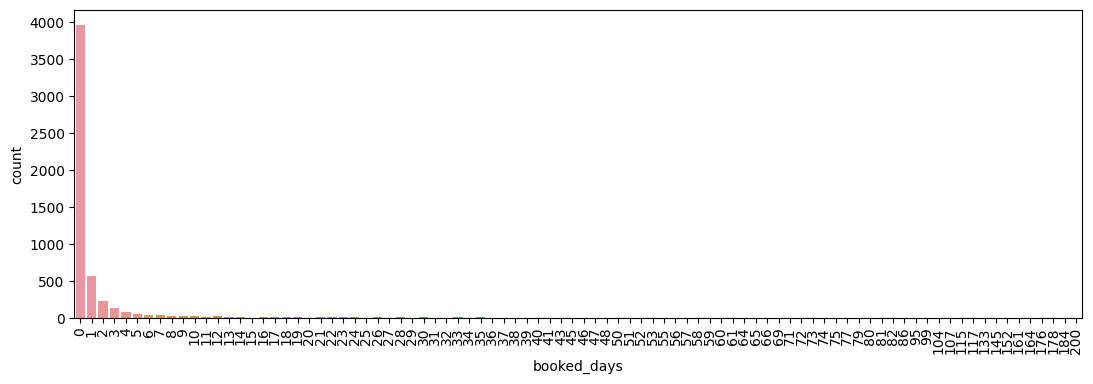

In [28]:
# 80% booking before a day and 90% booking before 4 days
print('Percentile 90 :',int(df_clean['booked_days'].quantile(.9)), 'days')
plt.figure(figsize=(13, 4))
sns.countplot(data=df_clean, x = 'booked_days')
plt.xticks(rotation=90)
plt.show()

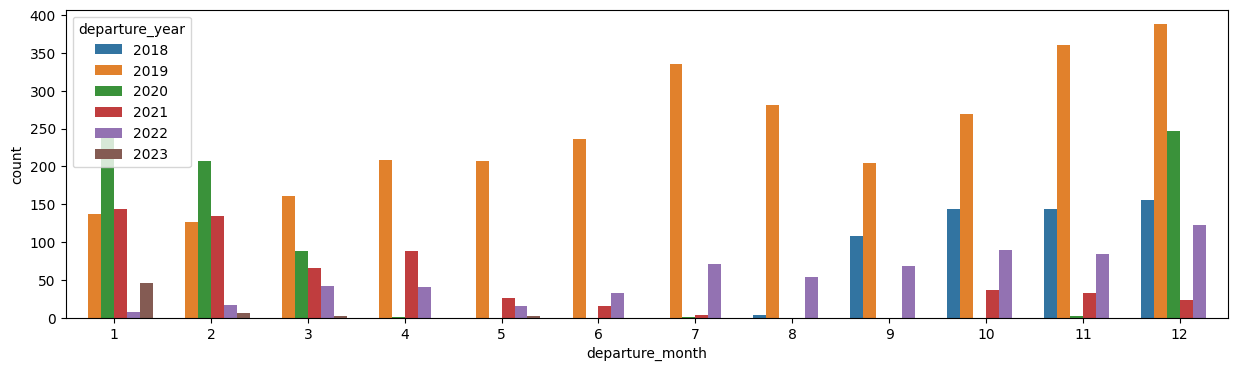

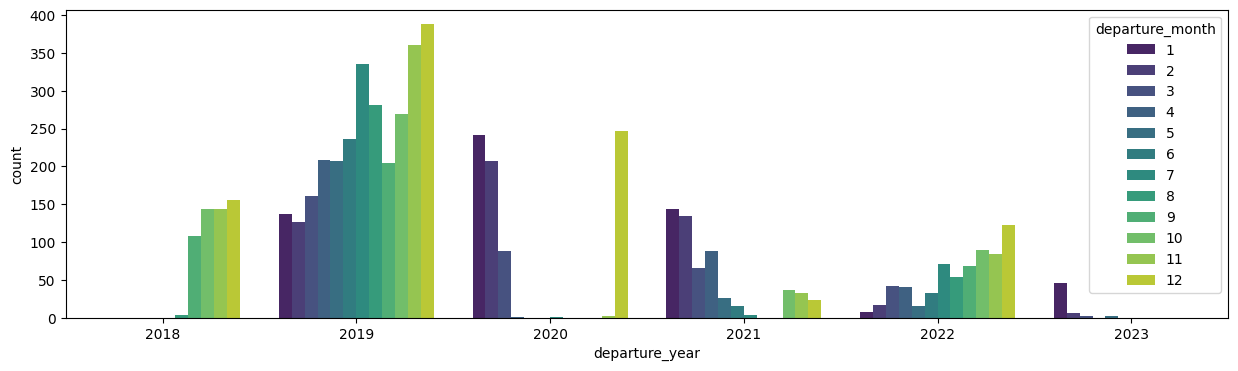

In [29]:
# high season start on September
plt.figure(figsize=(15, 4))
sns.countplot(data=df_clean, x = 'departure_month', hue='departure_year')
plt.show()
plt.figure(figsize=(15, 4))
sns.countplot(data=df_clean, x = 'departure_year', hue='departure_month', palette="viridis")
plt.show()

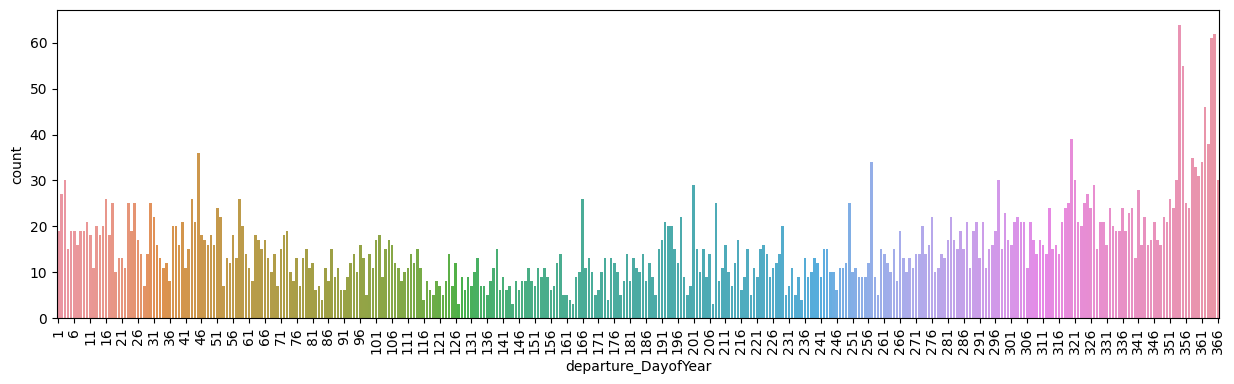

In [30]:
plt.figure(figsize=(15, 4))
sns.countplot(data=df_clean, x = 'departure_DayofYear')
plt.xticks(rotation=90)
plt.xticks(range(0, 366,5))
plt.show()

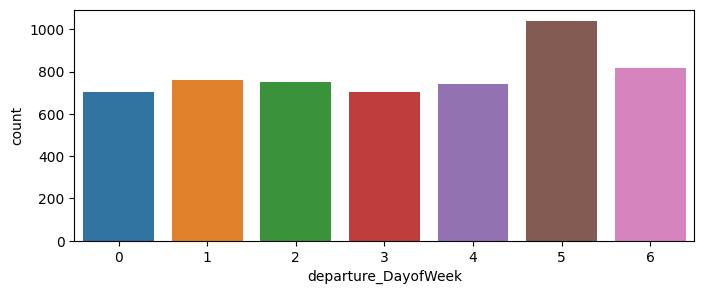

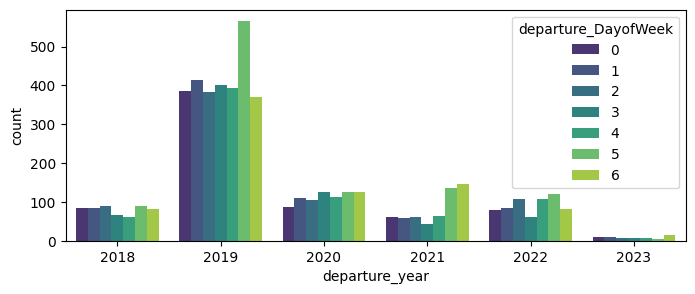

In [31]:
# departure date on Saturday and Sunday
plt.figure(figsize=(8, 3))
sns.countplot(data=df_clean, x = 'departure_DayofWeek')
plt.show()
plt.figure(figsize=(8, 3))
sns.countplot(data=df_clean, x = 'departure_year', hue='departure_DayofWeek', palette="viridis")
plt.show()

## ความสัมพันธ์ระหว่างประเทศ

218 : Thailand
105 : India
 77 : United Kingdom
 38 : Canada
 13 : Australia


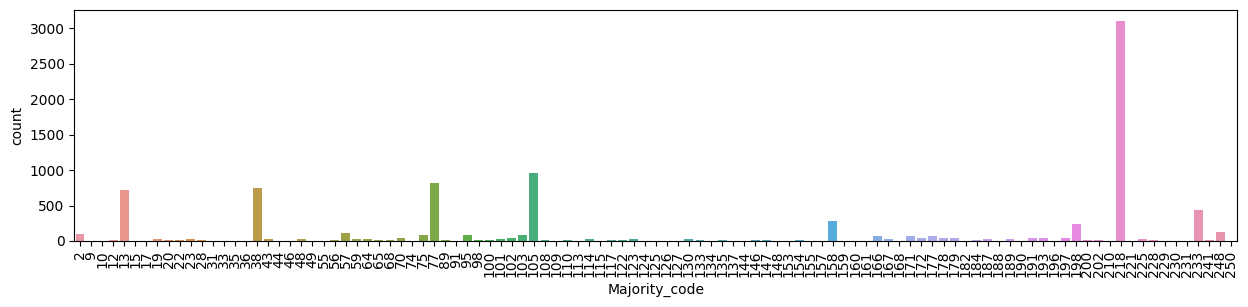

0:Mr. , 1:Ms. , 3:Mrs.


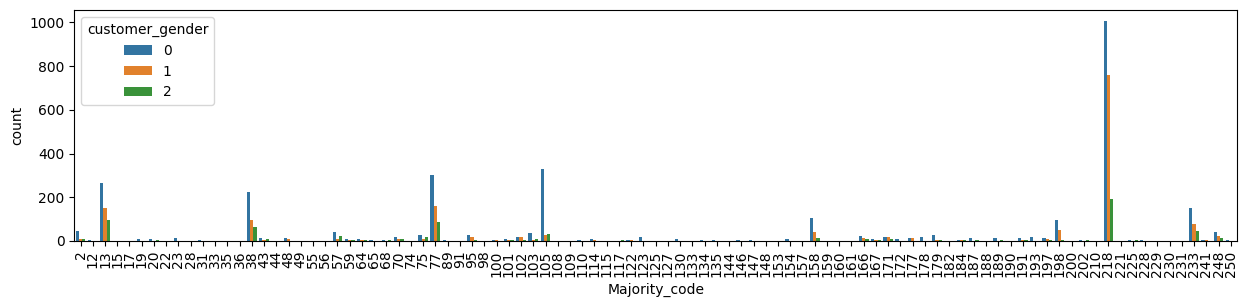

In [32]:
print(f'218 : {id_to_countryCode[218]}\n105 : {id_to_countryCode[105]}\n 77 : {id_to_countryCode[77]}\n 38 : {id_to_countryCode[38]}\n 13 : {id_to_countryCode[13]}')
plt.figure(figsize=(15, 3))
sns.countplot(data=df_order_v1, x = 'Majority_code')
plt.xticks(rotation=90)
plt.show()
print('0:Mr. , 1:Ms. , 3:Mrs.')
plt.figure(figsize=(15, 3))
sns.countplot(data=df_clean, x = 'Majority_code', hue='customer_gender')
plt.xticks(rotation=90)
plt.show()

0:Android Browse 1:AppleWebKit 2:Chrome 3:Edge 4:Windows 5:Firefox 6:MSIE 7:Opera Next 8:Safari 9:SamsungBrowser 10:Vivaldi -1:nan


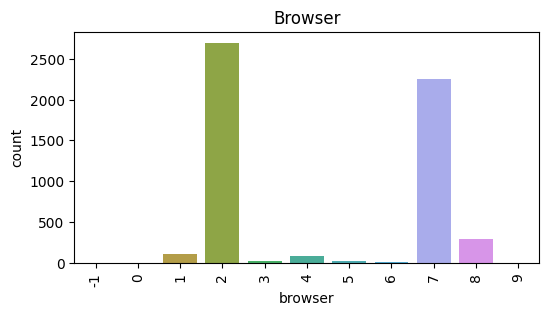

0:Android 1:Chrome OS 2:Linux 3:Macintosh 4:Windows 5:iPad 6:iPhone -1:nan


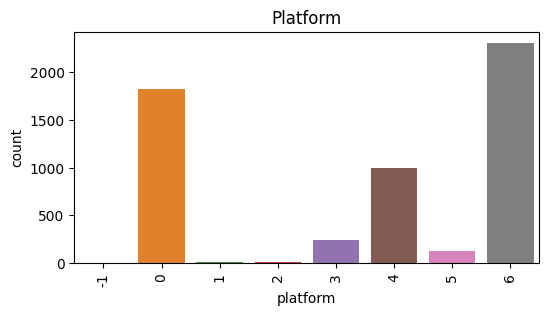

In [33]:
print('0:Android Browse', '1:AppleWebKit', '2:Chrome', '3:Edge', '4:Windows', '5:Firefox','6:MSIE', '7:Opera Next', '8:Safari','9:SamsungBrowser','10:Vivaldi','-1:nan')
plt.figure(figsize=(6, 3))
sns.countplot(data=df_clean, x = 'browser')
plt.xticks(rotation=90)
plt.title('Browser')
plt.show()

print('0:Android', '1:Chrome OS', '2:Linux', '3:Macintosh', '4:Windows', '5:iPad','6:iPhone', '-1:nan')
plt.figure(figsize=(6, 3))
sns.countplot(data=df_clean, x = 'platform')
plt.xticks(rotation=90)
plt.title('Platform')
plt.show()

## ความสัมพันธ์สินค้า

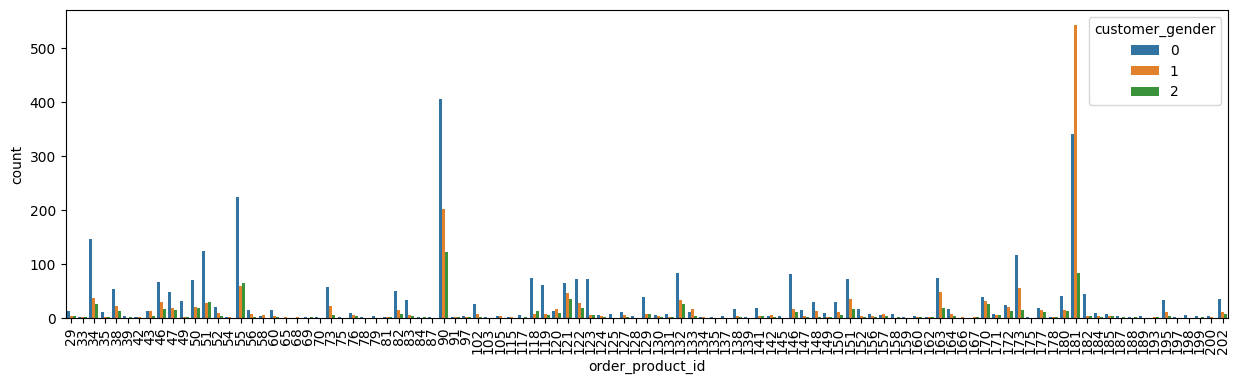

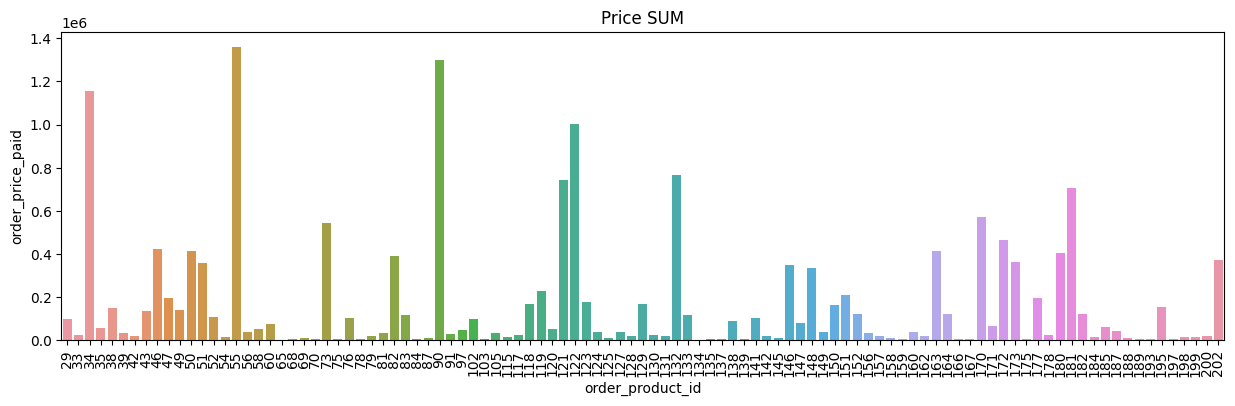

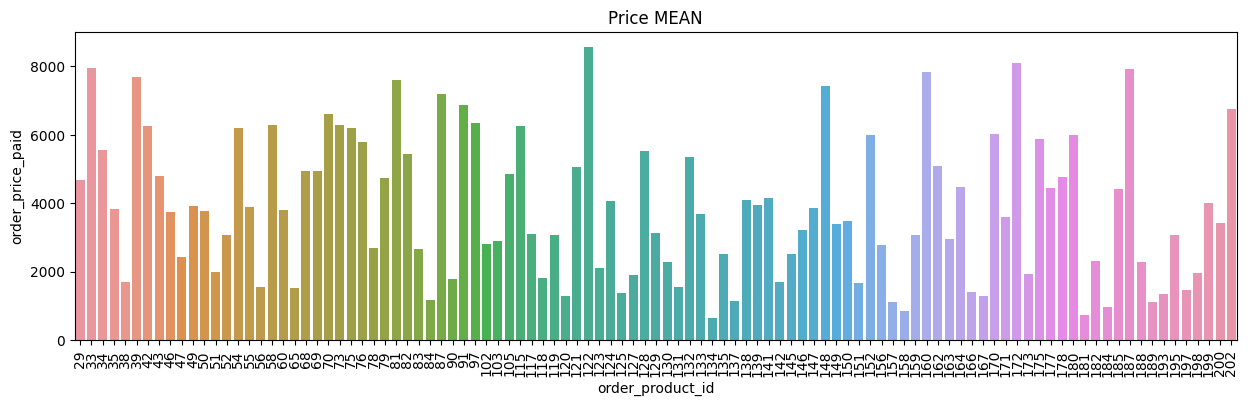

In [34]:
# product_id 181 
plt.figure(figsize=(15, 4))
sns.countplot(data=df_clean, x = 'order_product_id', hue='customer_gender')
plt.xticks(rotation=90)
plt.show()

df_group = df_clean[['order_product_id','order_price_paid']].groupby(['order_product_id']).sum()
plt.figure(figsize=(15, 4))
sns.barplot(data=df_group, x = df_group.index, y = df_group['order_price_paid'])
plt.xticks(rotation=90)
plt.title('Price SUM')
plt.show()

df_group = df_clean[['order_product_id','order_price_paid']].groupby(['order_product_id']).mean()
plt.figure(figsize=(15, 4))
sns.barplot(data=df_group, x = df_group.index, y = df_group['order_price_paid'])
plt.xticks(rotation=90)
plt.title('Price MEAN')
plt.show()

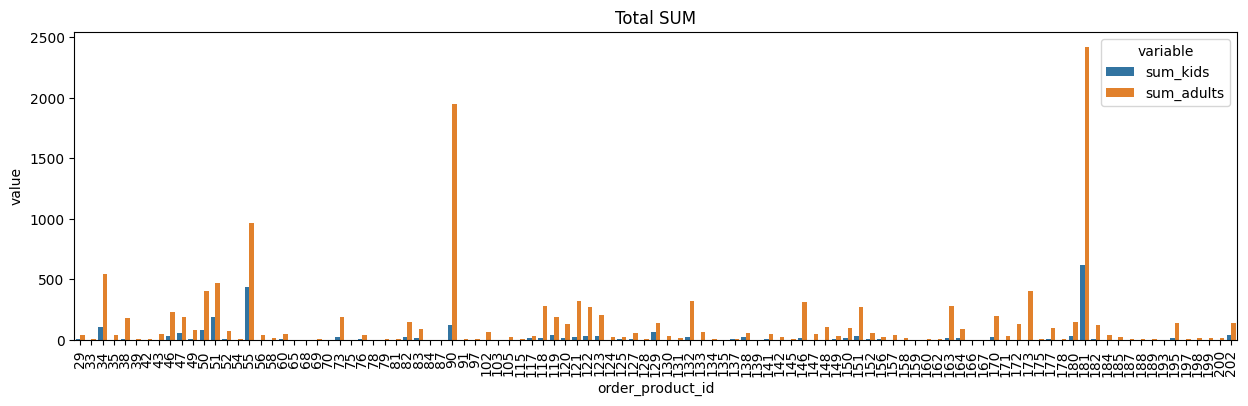

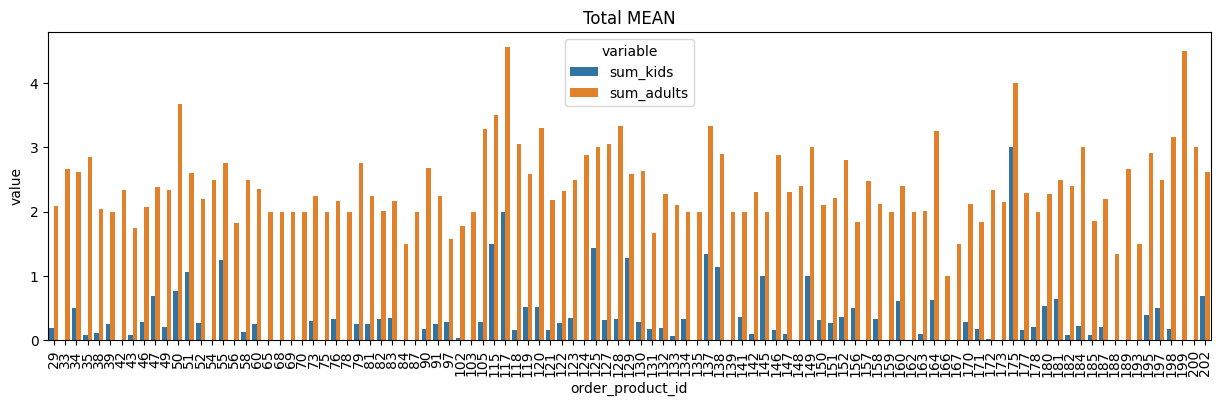

In [35]:
df_group = df_clean[['order_product_id','sum_kids', 'sum_adults']].groupby(['order_product_id'], as_index=False).sum()
df_group = df_group.melt(id_vars='order_product_id')
plt.figure(figsize=(15, 4))
sns.barplot(x='order_product_id', y='value', hue='variable', data=df_group)
plt.xticks(rotation=90)
plt.title('Total SUM')
plt.show()

df_group = df_clean[['order_product_id','sum_kids', 'sum_adults']].groupby(['order_product_id'], as_index=False).mean()
df_group = df_group.melt(id_vars='order_product_id')
plt.figure(figsize=(15, 4))
sns.barplot(x='order_product_id', y='value', hue='variable', data=df_group)
plt.xticks(rotation=90)
plt.title('Total MEAN')
plt.show()

# Add Category

In [36]:
product_cat_df = pd.read_csv('./csv/dtt_product_category.csv')

# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(product_cat_df['category_id'], prefix='cat')

# Group by 'product_id' and sum the one-hot encoded columns
grouped_df = one_hot_encoded.groupby(product_cat_df['product_id']).sum()

# Reset the index to make 'product_id' a column again
grouped_df = grouped_df.reset_index()

# Drop duplicate rows based on 'product_id'
product_cat_df = product_cat_df.drop_duplicates(subset='product_id')

# Merge the grouped DataFrame back to the original DataFrame
product_cat_df = pd.merge(product_cat_df.drop(columns=['category_id']), grouped_df, on='product_id')
product_cat_df.rename(columns={'product_id': 'order_product_id'}, inplace=True)
product_cat_df

,order_product_id,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,cat_14,cat_15,cat_16,cat_17,cat_18
0,22,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,23,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,26,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,300,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
320,301,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
321,303,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
322,305,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
df_clean_cat = pd.merge(df_clean, product_cat_df, on='order_product_id')
df_clean_cat

,customer_id,order_product_id,browser,platform,customer_firstname,customer_lastname,customer_email,customer_gender,Majority_code,order_price_paid,...,cat_9,cat_10,cat_11,cat_12,cat_13,cat_14,cat_15,cat_16,cat_17,cat_18
0,0,121,2,0,Julie,Staples,juliestaples40@gmail.com,2,77,4500,...,0,0,0,0,0,0,0,0,0,0
1,0,121,2,0,Alana,Locandro,alana.lannie@gmail.com,1,13,4500,...,0,0,0,0,0,0,0,0,0,0
2,0,121,7,6,Harriet,Peace,Harrietpeace@icloud.com,1,77,4500,...,0,0,0,0,0,0,0,0,0,0
3,221,121,8,0,Kain,Ingham,Kaino_01@hotmail.com,0,13,4500,...,0,0,0,0,0,0,0,0,0,0
4,0,121,2,4,Sandra,Nicholl,sandinicholl@hotmail.co.uk,2,77,15750,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,0,202,2,4,Ali,Mohammad,fourtwenty.aggregation@gmail.com,0,38,3580,...,0,0,0,0,0,1,0,0,0,0
5513,0,202,2,4,Kirill,Kiryushin,kirill.kiryushin.o@gmail.com,0,218,3980,...,0,0,0,0,0,1,0,0,0,0
5514,0,202,2,4,Paitoon,Uthaisang,puthaisang@gmail.com,0,218,7020,...,0,0,0,0,0,1,0,0,0,0
5515,0,202,2,0,Alex,Schetinin,shatz.g@gmail.com,0,103,3980,...,0,0,0,0,0,1,0,0,0,0


In [38]:
df_clean_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_id          5517 non-null   int64 
 1   order_product_id     5517 non-null   int64 
 2   browser              5517 non-null   int8  
 3   platform             5517 non-null   int8  
 4   customer_firstname   5517 non-null   object
 5   customer_lastname    5517 non-null   object
 6   customer_email       5517 non-null   object
 7   customer_gender      5517 non-null   int64 
 8   Majority_code        5517 non-null   int64 
 9   order_price_paid     5517 non-null   int64 
 10  order_payment_by     5517 non-null   int64 
 11  booked_days          5517 non-null   int64 
 12  departure_year       5517 non-null   int64 
 13  departure_month      5517 non-null   int64 
 14  departure_day        5517 non-null   int64 
 15  departure_DayofYear  5517 non-null   int64 
 16  depart

# Export for EDA and CSV file

In [39]:
report = sv.analyze(df_clean)
report.show_html('./report/clean_order_v1.html')
df_order_v1.to_csv('./csv/clean_order_v1.csv', index=False)

/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: F

Report ./report/clean_order_v1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [40]:
report = sv.analyze(df_clean_cat)
report.show_html('./report/clean_order_v2.html')
df_clean_cat.to_csv('./csv/clean_order_v2.csv', index=False)

/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/rootbeam/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: F

Report ./report/clean_order_v2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
